In [1]:
!jupyter lab --version

4.3.5


In [28]:
%matplotlib inline

In [29]:
!pip install biopython


[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
!pip install livelossplot


[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
import os
correct_path = 'C:/Users/Renee/major_project/'
os.chdir(correct_path)
print("Current working directory:", os.getcwd())
print(os.listdir())

Current working directory: C:\Users\Renee\major_project
['TriplexFPP']


In [37]:
import tensorflow as tf
import numpy as np
from Bio import SeqIO
import math
import pandas as pd
import csv
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, Flatten, Dropout, Dense, Input, Concatenate, Reshape, LSTM)
from tensorflow.keras.optimizers import Adam
from livelossplot import PlotLossesKerasTF as PlotLossesCallback

In [32]:
def countnum(seq,nuacid):
    return len([1 for i in range(len(seq)) if seq.startswith(nuacid,i)])

def construct_kmer():
	ntarr = ("A","C","G","T")

	kmerArray = []


	for n in range(4):
		kmerArray.append(ntarr[n])

	for n in range(4):
		str1 = ntarr[n]
		for m in range(4):
			str2 = str1 + ntarr[m]
			kmerArray.append(str2)
#############################################
	for n in range(4):
		str1 = ntarr[n]
		for m in range(4):
			str2 = str1 + ntarr[m]
			for x in range(4):
				str3 = str2 + ntarr[x]
				kmerArray.append(str3)
#############################################
#change this part for 3mer or 4mer
	for n in range(4):
		str1 = ntarr[n]
		for m in range(4):
			str2 = str1 + ntarr[m]
			for x in range(4):
				str3 = str2 + ntarr[x]
				for y in range(4):
					str4 = str3 + ntarr[y]
					kmerArray.append(str4)
############################################
	for n in range(4):
		str1 = ntarr[n]
		for m in range(4):
			str2 = str1 + ntarr[m]
			for x in range(4):
				str3 = str2 + ntarr[x]
				for y in range(4):
					str4 = str3 + ntarr[y]
					for z in range(4):
						str5 = str4 + ntarr[z]
						kmerArray.append(str5)
####################### 6-mer ##############
	for n in range(4):
		str1 = ntarr[n]
		for m in range(4):
			str2 = str1 + ntarr[m]
			for x in range(4):
				str3 = str2 + ntarr[x]
				for y in range(4):
					str4 = str3 + ntarr[y]
					for z in range(4):
						str5 = str4 + ntarr[z]
						for t in range(4):
							str6 = str5 + ntarr[t]
							kmerArray.append(str6)
    
	return kmerArray

def kmer_encode(seq,kmerarray):
    result = np.zeros((len(seq),len(kmerarray)))
    for i in range(len(seq)):
        for j in range(len(kmerarray)):
            result[i,j] = seq[i].count(kmerarray[j])/len(seq[i])
    return result

def mer_sin(seq, nc_m, c_m, kmerarray, x):   
    l = len(seq) - x + 1
    log_r = np.zeros((l))
    for i in range(l):
        tempseq = seq[i:i+x]        # first slice
        if 'N' in tempseq:          # if bad slice, skip
            log_r[i] = 0
            continue
        idx = kmerarray.index(tempseq)
        Fc = c_m[int(idx)]
        Fnc = nc_m[int(idx)]
        if Fc == 0 and Fnc == 0:
            log_r[i] = 0
        elif Fc == 0 and Fnc != 0:
            log_r[i] = -1
        elif Fnc == 0 and Fc != 0:
            log_r[i] = 1
        else:
            log_r[i] = np.log(Fc / Fnc)
    miu = sum(log_r) / l
    return miu
   
def mer_score(seq,nc_m,c_m,kmerarray,x):
    miu = np.zeros((len(seq)))
    for i in range(len(seq)):
        miu[i] = mer_sin(seq[i],nc_m,c_m,kmerarray,x)
        
    miu0 = np.expand_dims(miu, axis=1) #shape: N,1 where t=15K or 36K; assume N =batch size= 256
    return miu0

In [39]:
from Bio import SeqIO
lnc_521 = "TriplexFPP/input_example/lncrna/lncRNA_521.fasta"
lnc_36K = "TriplexFPP/input_example/lncrna/lncRNA_36K.fa"
output = "TriplexFPP/input_example/lncrna/lncRNA_521_700.fasta"

pos = list(SeqIO.parse(lnc_521, "fasta"))
neg = list(SeqIO.parse(lnc_36K, "fasta"))[:700]
lnc_1221 = pos + neg

SeqIO.write(lnc_1221,output,"fasta")
print(f"Saved {len(lnc_1221)} sequences to {output}")

Saved 1221 sequences to TriplexFPP/input_example/lncrna/lncRNA_521_700.fasta


In [40]:
def triplex_lncRNA(inputfile, datapath, outputname, train=False):
    print('Reading input FASTA...')
    records = list(SeqIO.parse(inputfile, "fasta"))
    seq = [str(record.seq) for record in records]
    name = [record.id for record in records]
    labels = np.array([1 if i < 521 else 0 for i in range(len(seq))])
   
    kmerArray = construct_kmer()
    kmer1 = kmer_encode(seq, kmerArray[0:4])
    kmer2 = kmer_encode(seq, kmerArray[4:20])
    kmer3 = kmer_encode(seq, kmerArray[20:84])

    pos = pd.read_csv(datapath + 'embed/mer_rnapos_mean.csv', header=None).values
    neg = pd.read_csv(datapath + 'embed/mer_rnaneg_mean.csv', header=None).values

    merscore1 = mer_score(seq, pos[0:4], neg[0:4], kmerArray[0:4], 1)
    merscore2 = mer_score(seq, pos[4:20], neg[4:20], kmerArray[4:20], 2)
    merscore3 = mer_score(seq, pos[20:84], neg[20:84], kmerArray[20:84], 3)
    merscore4 = mer_score(seq, pos[84:340], neg[84:340], kmerArray[84:340], 4)
    merscore5 = mer_score(seq, pos[340:1364], neg[340:1364], kmerArray[340:1364], 5)
    merscore6 = mer_score(seq, pos[1364:5460], neg[1364:5460], kmerArray[1364:5460], 6)

    fea = np.concatenate((merscore1, merscore2, merscore3, merscore4, merscore5, merscore6, kmer1, kmer2, kmer3), axis=1)
    traindata = np.expand_dims(fea, axis=2)  # shape: (N, 90, 1)
    labels_exp = np.expand_dims(labels, axis=(1, 2)) # shape: (N, 1, 1)
    traindata2 = np.concatenate((traindata, labels_exp), axis=1) # shape: (N, 91, 1)

    print(traindata2.shape)  # [[ [f1], [f2], ..., [f90], [label] ],   ... N times]
    np.random.seed(42)
    np.random.shuffle(traindata2)

    # Split features and labels
    train_data = traindata2[:, :90, :]  # (N, 90, 1) 
    labels = traindata2[:, 90, 0]       # (N,) 
    
    print(train_data.shape)
    print(labels.shape)
    print(labels[0:50])

    # Split data
    test_data = train_data[0:91, :, :]
    val_data = train_data[91:391, :, :]
    train_data_actual = train_data[391:, :, :]

    test_labels = labels[0:91]
    val_labels = labels[91:391]
    train_labels = labels[391:]

    np.save('TriplexFPP/test_data.npy', test_data)
    np.save('TriplexFPP/test_labels.npy', test_labels)

    input_layer = Input(shape=(90, 1))

    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
    y = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(input_layer)
    z = Conv1D(filters=64, kernel_size=7, activation='relu', padding='same')(input_layer)

    concat = Concatenate(axis=-1)([x, y, z])
    flat = Flatten()(concat)
    drop1 = Dropout(0.4)(flat)

    reshape = Reshape((1, -1))(drop1)

    lstm1 = LSTM(300, return_sequences=True)(reshape)
    lstm2 = LSTM(300)(lstm1)

    dense1 = Dense(256, activation='relu')(lstm2)
    drop2 = Dropout(0.4)(dense1)
    dense2 = Dense(128, activation='relu')(drop2)
    output = Dense(1, activation='sigmoid')(dense2)

    model = Model(inputs=input_layer, outputs=output)

    if train:
        optimizer = Adam(
            learning_rate=1e-5,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-08,
            amsgrad=False
        )

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        model.fit(train_data_actual, train_labels,
                  batch_size=32,
                  epochs=500, 
                  validation_data=(val_data, val_labels),
                  callbacks=[PlotLossesCallback()])

        model.save(datapath + 'train/' + 'train_lncRNA_1221.h5')
        print("Model saved.")

    else:
        model = load_model(datapath + 'train/' + 'train_lncRNA_1221.h5')
        probs = model.predict(inputfile).flatten()
        pred_classes = (probs >= 0.5).astype(int)
        pred_labels = ['Triplex' if cls == 1 else 'Nontriplex' for cls in pred_classes]

        with open(datapath + 'output/' + outputname, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerows(zip(name[:91], probs, pred_labels))

    return

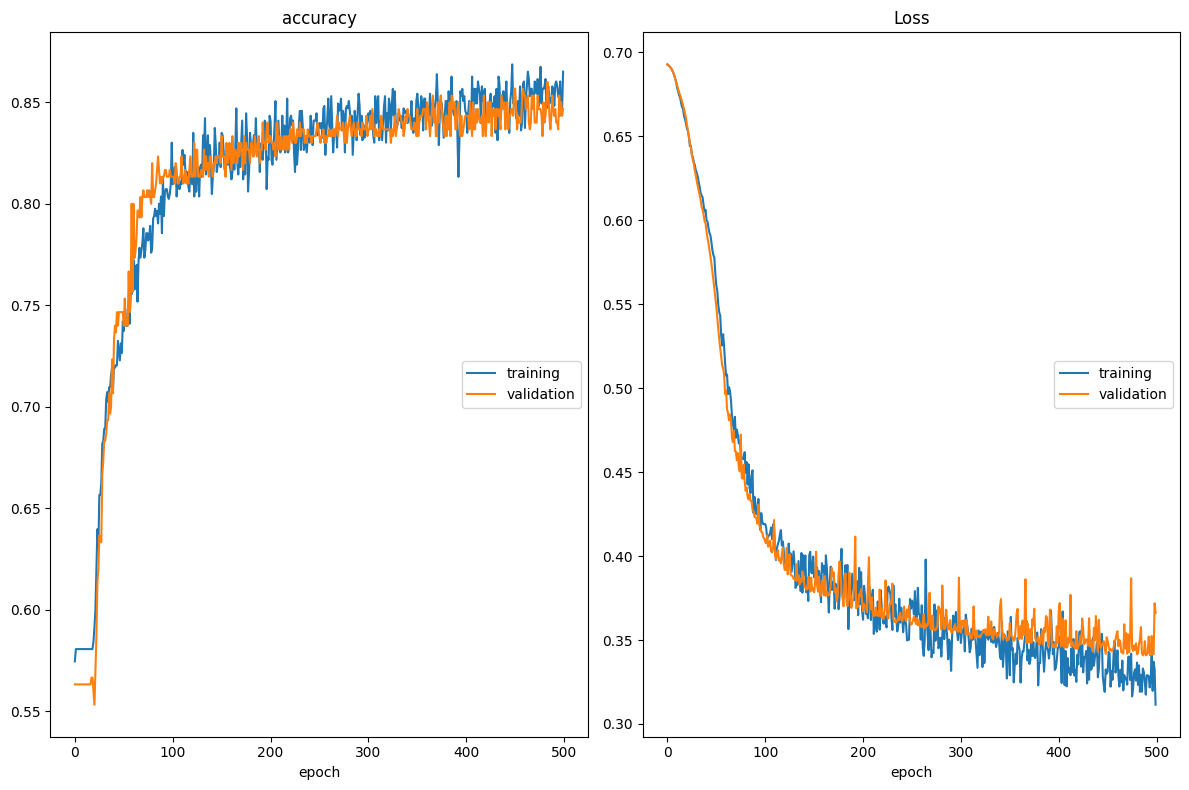

accuracy
	training         	 (min:    0.575, max:    0.869, cur:    0.865)
	validation       	 (min:    0.553, max:    0.860, cur:    0.847)
Loss
	training         	 (min:    0.311, max:    0.693, cur:    0.311)
	validation       	 (min:    0.341, max:    0.693, cur:    0.366)
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step - accuracy: 0.8711 - loss: 0.3132 - val_accuracy: 0.8467 - val_loss: 0.3661


Model saved.


In [23]:
datapath = 'TriplexFPP/'
inputfile = datapath + 'input_example/lncRNA_521_700.fasta'
print(inputfile)
outputname = 'test_lncrna_521_700.csv'
triplex_lncRNA(
    inputfile=inputfile,
    datapath=datapath,
    outputname=outputname,
    train=True
)

In [41]:
!pip install seaborn


[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    roc_auc_score, average_precision_score, f1_score,
    confusion_matrix, classification_report
)

def evaluate_model_performance(model_path, test_data_path, test_labels_path):
    # Load data
    test_data = np.load(test_data_path)
    test_labels = np.load(test_labels_path)

    # Load model using tf.keras
    model = tf.keras.models.load_model(model_path)
    probs = model.predict(test_data, verbose=0).flatten()
    pred_classes = (probs >= 0.5).astype(int)

    # Metrics
    acc = accuracy_score(test_labels, pred_classes)
    sen = recall_score(test_labels, pred_classes)
    tn, fp, fn, tp = confusion_matrix(test_labels, pred_classes).ravel()
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    auroc = roc_auc_score(test_labels, probs)
    auprc = average_precision_score(test_labels, probs)
    f1 = f1_score(test_labels, pred_classes)
    hm = 2 * (sen * spe) / (sen + spe) if (sen + spe) > 0 else 0.0

    # Print metrics
    print(f"Accuracy:      {acc:.4f}")
    print(f"Sensitivity:   {sen:.4f}")
    print(f"Specificity:   {spe:.4f}")
    print(f"AUROC:         {auroc:.4f}")
    print(f"AUPRC:         {auprc:.4f}")
    print(f"F1-Score:      {f1:.4f}")
    print(f"Harmonic Mean: {hm:.4f}\n")

    # Classification report
    print("Classification Report:")
    print(classification_report(test_labels, pred_classes, target_names=['Nontriplex', 'Triplex']))

    # Confusion matrix
    cm = confusion_matrix(test_labels, pred_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Nontriplex', 'Pred Triplex'],
                yticklabels=['True Nontriplex', 'True Triplex'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


Accuracy:      0.8571
Sensitivity:   0.8571
Specificity:   0.8571
AUROC:         0.9558
AUPRC:         0.9513
F1-Score:      0.8471
Harmonic Mean: 0.8571

Classification Report:
              precision    recall  f1-score   support

  Nontriplex       0.88      0.86      0.87        49
     Triplex       0.84      0.86      0.85        42

    accuracy                           0.86        91
   macro avg       0.86      0.86      0.86        91
weighted avg       0.86      0.86      0.86        91



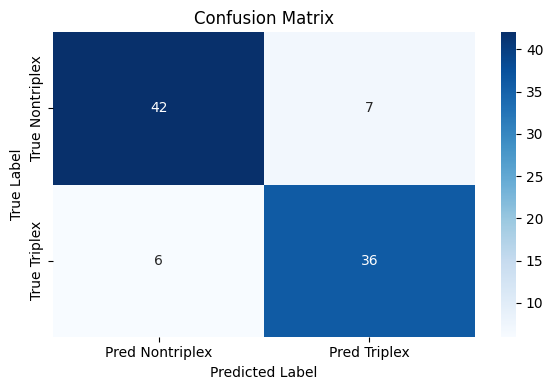

In [29]:
model_path = 'TriplexFPP/train/train_lncRNA_1221.h5'
test_data_path = 'TriplexFPP/test_data.npy'
test_labels_path = 'TriplexFPP/test_labels.npy'

evaluate_model_performance(model_path, test_data_path, test_labels_path)

In [17]:
def triplex_lncRNA(inputfile, datapath, outputname, train=False):
    print('Reading input FASTA...')
    records = list(SeqIO.parse(inputfile, "fasta"))
    seq = [str(record.seq) for record in records]
    name = [record.id for record in records]

    labels = np.array([1 if i < 521 else 0 for i in range(len(seq))])
   
    kmerArray = construct_kmer()
    kmer1 = kmer_encode(seq, kmerArray[0:4])
    kmer2 = kmer_encode(seq, kmerArray[4:20])
    kmer3 = kmer_encode(seq, kmerArray[20:84])

    pos = pd.read_csv(datapath + 'embed/mer_rnapos_mean.csv', header=None).values
    neg = pd.read_csv(datapath + 'embed/mer_rnaneg_mean.csv', header=None).values

    merscore1 = mer_score(seq, pos[0:4], neg[0:4], kmerArray[0:4], 1)
    merscore2 = mer_score(seq, pos[4:20], neg[4:20], kmerArray[4:20], 2)
    merscore3 = mer_score(seq, pos[20:84], neg[20:84], kmerArray[20:84], 3)
    merscore4 = mer_score(seq, pos[84:340], neg[84:340], kmerArray[84:340], 4)
    merscore5 = mer_score(seq, pos[340:1364], neg[340:1364], kmerArray[340:1364], 5)
    merscore6 = mer_score(seq, pos[1364:5460], neg[1364:5460], kmerArray[1364:5460], 6)

    fea = np.concatenate((merscore1, merscore2, merscore3, merscore4, merscore5, merscore6, kmer1, kmer2, kmer3), axis=1)
    traindata = np.expand_dims(fea, axis=2)  # shape: (N, 90, 1)
    labels_exp = np.expand_dims(labels, axis=(1, 2)) # shape: (N, 1, 1)
    traindata2 = np.concatenate((traindata, labels_exp), axis=1) # shape: (N, 91, 1)
    train_data = traindata2[:, :90, :]  # (N, 90, 1) 
    labels = traindata2[:, 90, 0]       # (N,) 
    test_data = train_data[0:10, :, :]
    test_labels = labels[0:10]
    np.save('TriplexFPP/test_data_10.npy', test_data)
    np.save('TriplexFPP/test_labels_10.npy', test_labels)
    
    if train:
        print(traindata2.shape)  # [[ [f1], [f2], ..., [f90], [label] ],   ... N times]
        np.random.seed(42)
        np.random.shuffle(traindata2)
    
        # Split features and labels
        train_data = traindata2[:, :90, :]  # (N, 90, 1) 
        labels = traindata2[:, 90, 0]       # (N,) 
        
        print(train_data.shape)
        print(labels.shape)
        print(labels[0:50])
    
        # Split data
        test_data = train_data[0:91, :, :]
        val_data = train_data[91:391, :, :]
        train_data_actual = train_data[391:, :, :]
    
        test_labels = labels[0:91]
        val_labels = labels[91:391]
        train_labels = labels[391:]


        input_layer = Input(shape=(90, 1))
    
        x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
        y = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(input_layer)
        z = Conv1D(filters=64, kernel_size=7, activation='relu', padding='same')(input_layer)
    
        concat = Concatenate(axis=-1)([x, y, z])
        flat = Flatten()(concat)
        drop1 = Dropout(0.4)(flat)
    
        reshape = Reshape((1, -1))(drop1)
    
        lstm1 = LSTM(300, return_sequences=True)(reshape)
        lstm2 = LSTM(300)(lstm1)
    
        dense1 = Dense(256, activation='relu')(lstm2)
        drop2 = Dropout(0.4)(dense1)
        dense2 = Dense(128, activation='relu')(drop2)
        output = Dense(1, activation='sigmoid')(dense2)
    
        model = Model(inputs=input_layer, outputs=output)

        optimizer = Adam(
            learning_rate=1e-5,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-08,
            amsgrad=False
        )

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        model.fit(train_data_actual, train_labels,
                  batch_size=32,
                  epochs=500, 
                  validation_data=(val_data, val_labels),
                  callbacks=[PlotLossesCallback()])

        model.save(datapath + 'train/' + 'train_lncRNA_1221.h5')
        print("Model saved.")

    else:
        model = load_model(datapath + 'train/' + 'train_lncRNA_1221.h5')
        probs = model.predict(test_data).flatten()
        pred_classes = (probs >= 0.5).astype(int)
        pred_labels = ['Triplex' if cls == 1 else 'Nontriplex' for cls in pred_classes]

        with open(datapath + 'output/' + outputname, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerows(zip(name[:10], probs, pred_labels))

    return

In [ ]:
datapath = 'TriplexFPP/'
inputfile = datapath + 'input_example/lncRNA/triplexlncRNA_test.fasta'
print(inputfile)
outputname = 'test_lncrna_521_700.csv'
triplex_lncRNA(
    inputfile=inputfile,
    datapath=datapath,
    outputname=outputname,
    train=False
)

In [ ]:
!pip install gradio

In [12]:
import gradio as gr 
print (gr.__version__)

5.31.0


In [36]:
import gradio as gr
import pandas as pd

# Load prediction and metadata
df = pd.read_csv("TriplexFPP/output/test_lncrna_521_700.csv", header=None)
df.columns = ["Full ID", "Probability", "Prediction"]

# Parse metadata
def parse_metadata(full_id):
    parts = full_id.strip("|").split("|")
    return {
        "Transcript ID": parts[0],
        "Gene ID": parts[1],
        "HAVANA Gene ID": parts[2],
        "HAVANA Transcript ID": parts[3],
        "Transcript Alias": parts[4],
        "Gene Symbol": parts[5],
        "Sequence Length": int(parts[6]) if parts[6].isdigit() else None
    }

meta_df = pd.DataFrame([parse_metadata(fid) for fid in df["Full ID"]])
full_df = pd.concat([meta_df, df[["Probability", "Prediction"]]], axis=1)

# Dropdown sync functions
def update_from_transcript(transcript_id):
    row = full_df[full_df["Transcript ID"] == transcript_id].iloc[0]
    return (
        gr.update(choices=sorted(full_df["Gene ID"].unique()), value=row["Gene ID"]),
        gr.update(choices=sorted(full_df["Transcript Alias"].unique()), value=row["Transcript Alias"])
    )

def update_from_gene(gene_id):
    row = full_df[full_df["Gene ID"] == gene_id].iloc[0]
    return (
        gr.update(choices=sorted(full_df["Transcript ID"].unique()), value=row["Transcript ID"]),
        gr.update(choices=sorted(full_df["Transcript Alias"].unique()), value=row["Transcript Alias"])
    )

def update_from_alias(alias):
    row = full_df[full_df["Transcript Alias"] == alias].iloc[0]
    return (
        gr.update(choices=sorted(full_df["Transcript ID"].unique()), value=row["Transcript ID"]),
        gr.update(choices=sorted(full_df["Gene ID"].unique()), value=row["Gene ID"])
    )

# Prediction output
def get_result(transcript_id, gene_id, alias_id):
    row = full_df[
        (full_df["Transcript ID"] == transcript_id) &
        (full_df["Gene ID"] == gene_id) &
        (full_df["Transcript Alias"] == alias_id)
    ]
    if row.empty:
        return "⚠️ No matching entry found."
    row = row.iloc[0]
    return (
        f"📌 Transcript ID           : {row['Transcript ID']}\n"
        f"🧬 Gene ID                 : {row['Gene ID']}\n"
        f"🔖 Transcript Alias        : {row['Transcript Alias']}\n"
        f"🧫 HAVANA Gene ID          : {row['HAVANA Gene ID']}\n"
        f"🧪 HAVANA Transcript ID    : {row['HAVANA Transcript ID']}\n"
        f"📏 Sequence Length         : {row['Sequence Length']} bp\n\n"
        f"🧠 Prediction              : {row['Prediction']}\n"
        f"📈 Probability of Triplex  : {row['Probability']:.3f}"
    )

# Interface layout
with gr.Blocks(theme=gr.themes.Soft(primary_hue="blue")) as demo:
    gr.HTML("""
    <style>
        textarea, input[type=text] {
            font-family: 'Courier New', monospace !important;
            white-space: pre;
        }

        #output-box textarea {
            width: 400px !important;
            font-weight: bold !important;
            font-size: 14px;
        }

        /* Style dropdowns to reduce width and use monospace font */
        #transcript-dropdown select,
        #gene-dropdown select,
        #alias-dropdown select {
            width: 240px !important;
            font-family: 'Courier New', monospace !important;
            font-weight: bold !important;
            font-size: 13px;
        }
    </style>
    """)

    gr.Markdown("## 🔬 **Demo: Predicting Triplex-Forming Potential in lncRNAs**")
    gr.Markdown("Select an lncRNA sequence using its Transcript ID, Gene ID, or Transcript Alias from the dropdown menu.")

    with gr.Row(equal_height=True):
        with gr.Column(scale=1):
            transcript_dropdown = gr.Dropdown(
                choices=sorted(full_df["Transcript ID"].unique().tolist()),
                label="🧾 Transcript ID",
                interactive=True,
                elem_id="transcript-dropdown"
            )
            gene_dropdown = gr.Dropdown(
                choices=sorted(full_df["Gene ID"].unique().tolist()),
                label="🧬 Gene ID",
                interactive=True,
                elem_id="gene-dropdown"
            )
            alias_dropdown = gr.Dropdown(
                choices=sorted(full_df["Transcript Alias"].unique().tolist()),
                label="🔖 Transcript Alias",
                interactive=True,
                elem_id="alias-dropdown"
            )
            predict_btn = gr.Button("🔍 Get Prediction")

        with gr.Column(scale=1):
            output_box = gr.Textbox(
                label="📊 Prediction & Metadata",
                lines=10,
                show_copy_button=True,
                elem_id="output-box"
            )

    # Link dropdown updates
    transcript_dropdown.change(update_from_transcript, transcript_dropdown, [gene_dropdown, alias_dropdown])
    gene_dropdown.change(update_from_gene, gene_dropdown, [transcript_dropdown, alias_dropdown])
    alias_dropdown.change(update_from_alias, alias_dropdown, [transcript_dropdown, gene_dropdown])

    # Actions
    predict_btn.click(get_result, [transcript_dropdown, gene_dropdown, alias_dropdown], output_box)

demo.launch(share=True)


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://11c3193c2a903bde53.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [1]:
from sklearn.model_selection import KFold
from keras.models import Model, load_model
from keras.layers import Input, Conv1D, Concatenate, Flatten, Dropout, Reshape, LSTM, Dense
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import csv
from Bio import SeqIO

def triplex_lncRNA(inputfile, datapath, outputname, train=False):
    print('Reading input FASTA...')
    records = list(SeqIO.parse(inputfile, "fasta"))
    seq = [str(record.seq) for record in records]
    name = [record.id for record in records]
    labels = np.array([1 if i < 521 else 0 for i in range(len(seq))])

    kmerArray = construct_kmer()
    kmer1 = kmer_encode(seq, kmerArray[0:4])
    kmer2 = kmer_encode(seq, kmerArray[4:20])
    kmer3 = kmer_encode(seq, kmerArray[20:84])

    pos = pd.read_csv(datapath + 'embed/mer_rnapos_mean.csv', header=None).values
    neg = pd.read_csv(datapath + 'embed/mer_rnaneg_mean.csv', header=None).values

    merscore1 = mer_score(seq, pos[0:4], neg[0:4], kmerArray[0:4], 1)
    merscore2 = mer_score(seq, pos[4:20], neg[4:20], kmerArray[4:20], 2)
    merscore3 = mer_score(seq, pos[20:84], neg[20:84], kmerArray[20:84], 3)
    merscore4 = mer_score(seq, pos[84:340], neg[84:340], kmerArray[84:340], 4)
    merscore5 = mer_score(seq, pos[340:1364], neg[340:1364], kmerArray[340:1364], 5)
    merscore6 = mer_score(seq, pos[1364:5460], neg[1364:5460], kmerArray[1364:5460], 6)

    fea = np.concatenate((merscore1, merscore2, merscore3, merscore4, merscore5, merscore6, kmer1, kmer2, kmer3), axis=1)
    traindata = np.expand_dims(fea, axis=2)  # shape: (N, 90, 1)
    labels_exp = np.expand_dims(labels, axis=(1, 2))  # shape: (N, 1, 1)
    traindata2 = np.concatenate((traindata, labels_exp), axis=1)  # shape: (N, 91, 1)

    np.random.seed(42)
    np.random.shuffle(traindata2)

    data = traindata2[:, :90, :]
    labels = traindata2[:, 90, 0]

    np.save('TriplexFPP/test_data.npy', data[0:91])
    np.save('TriplexFPP/test_labels.npy', labels[0:91])

    def build_model():
        input_layer = Input(shape=(90, 1))
        x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
        y = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(input_layer)
        z = Conv1D(filters=64, kernel_size=7, activation='relu', padding='same')(input_layer)
        concat = Concatenate(axis=-1)([x, y, z])
        flat = Flatten()(concat)
        drop1 = Dropout(0.4)(flat)
        reshape = Reshape((1, -1))(drop1)
        lstm1 = LSTM(300, return_sequences=True)(reshape)
        lstm2 = LSTM(300)(lstm1)
        dense1 = Dense(256, activation='relu')(lstm2)
        drop2 = Dropout(0.4)(dense1)
        dense2 = Dense(128, activation='relu')(drop2)
        output = Dense(1, activation='sigmoid')(dense2)
        model = Model(inputs=input_layer, outputs=output)
        return model

    if train:
        print("Starting 5-fold cross-validation...")
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
            print(f"\nTraining Fold {fold+1}...")
            train_data_fold, val_data_fold = data[train_idx], data[val_idx]
            train_labels_fold, val_labels_fold = labels[train_idx], labels[val_idx]

            model = build_model()
            optimizer = Adam(
                learning_rate=1e-5,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-08,
                amsgrad=False
            )
            model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

            model.fit(train_data_fold, train_labels_fold,
                      batch_size=32,
                      epochs=500,
                      validation_data=(val_data_fold, val_labels_fold),
                      callbacks=[PlotLossesCallback()])

            model.save(datapath + f'train/train_lncRNA_fold{fold+1}.h5')
            print(f"Model for fold {fold+1} saved.")

    else:
        #model = load_model(datapath + 'train/train_lncRNA_fold1.h5')
        probs = model.predict(data[0:91]).flatten()
        pred_classes = (probs >= 0.5).astype(int)
        pred_labels = ['Triplex' if cls == 1 else 'Nontriplex' for cls in pred_classes]

        with open(datapath + 'output/' + outputname, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerows(zip(name[:91], probs, pred_labels))

    return


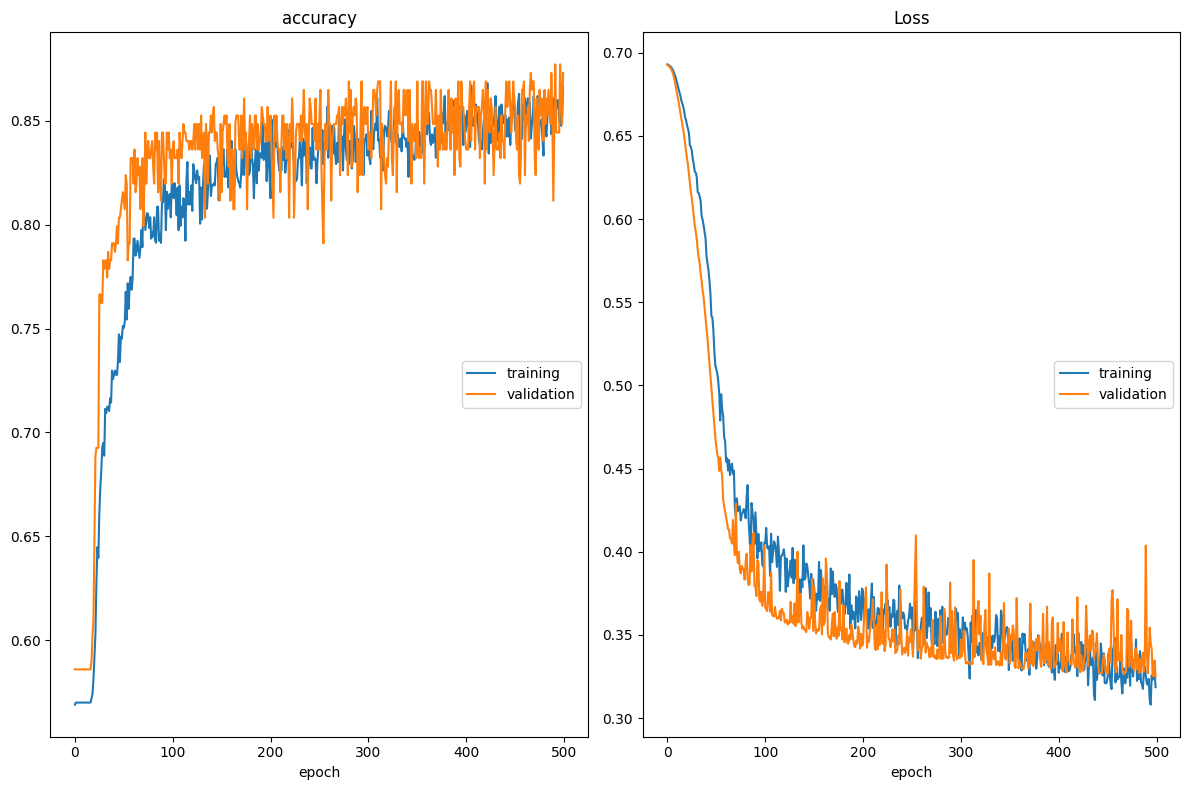

accuracy
	training         	 (min:    0.569, max:    0.868, cur:    0.866)
	validation       	 (min:    0.586, max:    0.877, cur:    0.873)
Loss
	training         	 (min:    0.308, max:    0.693, cur:    0.319)
	validation       	 (min:    0.325, max:    0.693, cur:    0.325)
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.8512 - loss: 0.3385 - val_accuracy: 0.8730 - val_loss: 0.3249


Model for fold 5 saved.


In [14]:
datapath = 'TriplexFPP/'
inputfile = datapath + 'input_example/lncRNA/lncRNA_521_700.fasta'
print(inputfile)
outputname = 'test_lncrna_521_700.csv'
triplex_lncRNA(
    inputfile=inputfile,
    datapath=datapath,
    outputname=outputname,
    train=True
)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import load_model
import numpy as np
import csv

def evaluate_crossval_folds(datapath, output_csv='ensemble_predictions.csv'):
    test_data = np.load('TriplexFPP/test_data.npy')
    test_labels = np.load('TriplexFPP/test_labels.npy')

    all_probs = []
    all_preds = []

    print("Evaluating all 5 folds...")

    for fold in range(1, 6):
        print(f"\nFold {fold}:")
        model_path = datapath + f'train/train_lncRNA_fold{fold}.h5'
        model = load_model(model_path)
        probs = model.predict(test_data).flatten()
        preds = (probs >= 0.5).astype(int)

        all_probs.append(probs)
        all_preds.append(preds)

        acc = accuracy_score(test_labels, preds)
        prec = precision_score(test_labels, preds)
        rec = recall_score(test_labels, preds)
        f1 = f1_score(test_labels, preds)

        print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    # Majority voting
    all_preds = np.array(all_preds)
    majority_vote = np.round(np.mean(all_preds, axis=0)).astype(int)

    # Ensemble metrics
    print("\nEnsemble Majority Voting Results:")
    acc = accuracy_score(test_labels, majority_vote)
    prec = precision_score(test_labels, majority_vote)
    rec = recall_score(test_labels, majority_vote)
    f1 = f1_score(test_labels, majority_vote)

    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    # Save to CSV
    probs_mean = np.mean(np.array(all_probs), axis=0)
    final_labels = ['Triplex' if p == 1 else 'Nontriplex' for p in majority_vote]

    with open(datapath + 'output/' + output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Index', 'Probability', 'Predicted Label'])
        for i, (p, lbl) in enumerate(zip(probs_mean, final_labels)):
            writer.writerow([i+1, round(p, 4), lbl])

    print(f"\nEnsemble predictions saved to: {datapath + 'output/' + output_csv}")


In [17]:
evaluate_crossval_folds(datapath='TriplexFPP/', output_csv='cross_validation_results.csv') #modify!!

Evaluating all 5 folds...

Fold 1:


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
Accuracy: 0.8901 | Precision: 0.8810 | Recall: 0.8810 | F1: 0.8810

Fold 2:


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step
Accuracy: 0.8791 | Precision: 0.9189 | Recall: 0.8095 | F1: 0.8608

Fold 3:


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step
Accuracy: 0.8681 | Precision: 0.8947 | Recall: 0.8095 | F1: 0.8500

Fold 4:


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step
Accuracy: 0.8791 | Precision: 0.8780 | Recall: 0.8571 | F1: 0.8675

Fold 5:


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step
Accuracy: 0.8791 | Precision: 0.8605 | Recall: 0.8810 | F1: 0.8706

Ensemble Majority Voting Results:
Accuracy: 0.8681 | Precision: 0.8571 | Recall: 0.8571 | F1: 0.8571

Ensemble predictions saved to: TriplexFPP/output/cross_validation_results.csv


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import load_model
import numpy as np
import csv

def evaluate_crossval_folds(datapath, output_csv='ensemble_predictions.csv'):
    test_data = np.load('TriplexFPP/test_data_10.npy')
    test_labels = np.load('TriplexFPP/test_labels_10.npy')

    all_probs = []
    all_preds = []

    print("Evaluating all 5 folds...")

    for fold in range(1, 6):
        print(f"\nFold {fold}:")
        model_path = datapath + f'train/train_lncRNA_fold{fold}.h5'
        model = load_model(model_path)
        probs = model.predict(test_data).flatten()
        preds = (probs >= 0.5).astype(int)

        all_probs.append(probs)
        all_preds.append(preds)

        acc = accuracy_score(test_labels, preds)
        prec = precision_score(test_labels, preds)
        rec = recall_score(test_labels, preds)
        f1 = f1_score(test_labels, preds)

        print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    # Majority voting
    all_preds = np.array(all_preds)
    majority_vote = np.round(np.mean(all_preds, axis=0)).astype(int)

    # Ensemble metrics
    print("\nEnsemble Majority Voting Results:")
    acc = accuracy_score(test_labels, majority_vote)
    prec = precision_score(test_labels, majority_vote)
    rec = recall_score(test_labels, majority_vote)
    f1 = f1_score(test_labels, majority_vote)

    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    # Save to CSV
    probs_mean = np.mean(np.array(all_probs), axis=0)
    final_labels = ['Triplex' if p == 1 else 'Nontriplex' for p in majority_vote]

    with open(datapath + 'output/' + output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Index', 'Probability', 'Predicted Label'])
        for i, (p, lbl) in enumerate(zip(probs_mean, final_labels)):
            writer.writerow([i+1, round(p, 4), lbl])

    print(f"\nEnsemble predictions saved to: {datapath + 'output/' + output_csv}")


In [25]:
evaluate_crossval_folds(datapath='TriplexFPP/', output_csv='cross_validation_test_lncrna_10.csv') #modify!!

Evaluating all 5 folds...

Fold 1:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
Accuracy: 0.9000 | Precision: 1.0000 | Recall: 0.9000 | F1: 0.9474

Fold 2:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
Accuracy: 0.8000 | Precision: 1.0000 | Recall: 0.8000 | F1: 0.8889

Fold 3:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
Accuracy: 0.9000 | Precision: 1.0000 | Recall: 0.9000 | F1: 0.9474

Fold 4:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
Accuracy: 0.8000 | Precision: 1.0000 | Recall: 0.8000 | F1: 0.8889

Fold 5:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
Accuracy: 0.9000 | Precision: 1.0000 | Recall: 0.9000 | F1: 0.9474

Ensemble Majority Voting Results:
Accuracy: 0.9000 | Precision: 1.0000 | Recall: 0.9000 | F1: 0.9474

Ensemble predictions saved to: TriplexFPP/output/cross_validation_test_lncrna_10.csv



=== Fold 1 ===


Accuracy:      0.8901
Sensitivity:   0.8810
Specificity:   0.8980
AUROC:         0.9670
AUPRC:         0.9650
F1-Score:      0.8810
Harmonic Mean: 0.8894

Classification Report:
              precision    recall  f1-score   support

  Nontriplex       0.90      0.90      0.90        49
     Triplex       0.88      0.88      0.88        42

    accuracy                           0.89        91
   macro avg       0.89      0.89      0.89        91
weighted avg       0.89      0.89      0.89        91



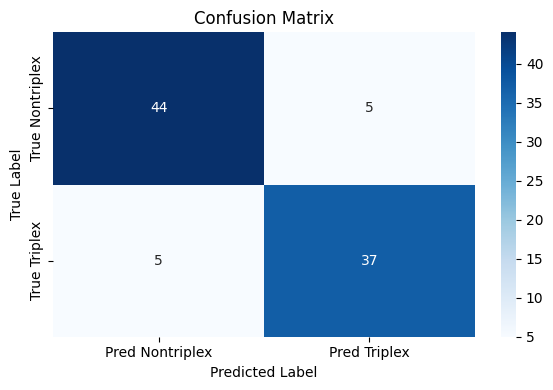


=== Fold 2 ===


Accuracy:      0.8791
Sensitivity:   0.8095
Specificity:   0.9388
AUROC:         0.9650
AUPRC:         0.9645
F1-Score:      0.8608
Harmonic Mean: 0.8694

Classification Report:
              precision    recall  f1-score   support

  Nontriplex       0.85      0.94      0.89        49
     Triplex       0.92      0.81      0.86        42

    accuracy                           0.88        91
   macro avg       0.89      0.87      0.88        91
weighted avg       0.88      0.88      0.88        91



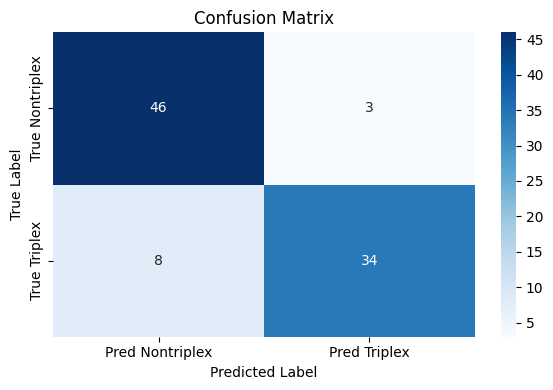


=== Fold 3 ===


Accuracy:      0.8681
Sensitivity:   0.8095
Specificity:   0.9184
AUROC:         0.9679
AUPRC:         0.9646
F1-Score:      0.8500
Harmonic Mean: 0.8605

Classification Report:
              precision    recall  f1-score   support

  Nontriplex       0.85      0.92      0.88        49
     Triplex       0.89      0.81      0.85        42

    accuracy                           0.87        91
   macro avg       0.87      0.86      0.87        91
weighted avg       0.87      0.87      0.87        91



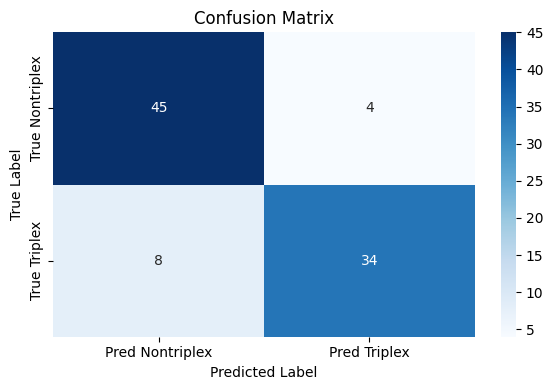


=== Fold 4 ===


Accuracy:      0.8791
Sensitivity:   0.8571
Specificity:   0.8980
AUROC:         0.9665
AUPRC:         0.9657
F1-Score:      0.8675
Harmonic Mean: 0.8771

Classification Report:
              precision    recall  f1-score   support

  Nontriplex       0.88      0.90      0.89        49
     Triplex       0.88      0.86      0.87        42

    accuracy                           0.88        91
   macro avg       0.88      0.88      0.88        91
weighted avg       0.88      0.88      0.88        91



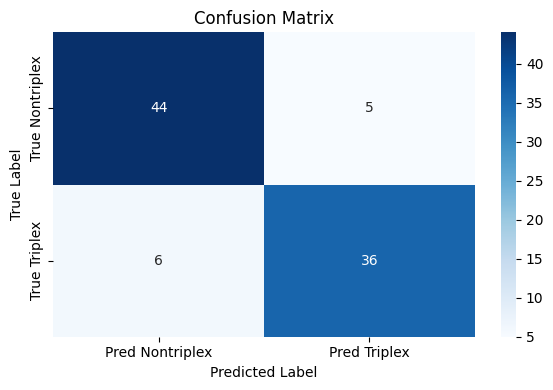


=== Fold 5 ===


Accuracy:      0.8791
Sensitivity:   0.8810
Specificity:   0.8776
AUROC:         0.9660
AUPRC:         0.9659
F1-Score:      0.8706
Harmonic Mean: 0.8792

Classification Report:
              precision    recall  f1-score   support

  Nontriplex       0.90      0.88      0.89        49
     Triplex       0.86      0.88      0.87        42

    accuracy                           0.88        91
   macro avg       0.88      0.88      0.88        91
weighted avg       0.88      0.88      0.88        91



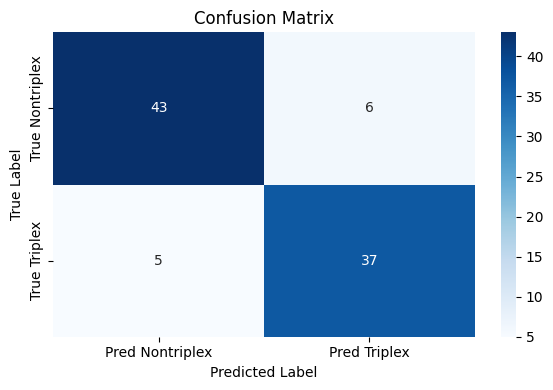

In [19]:
for fold in range(1, 6):
    print(f"\n=== Fold {fold} ===")
    model_path = f"TriplexFPP/train/train_lncRNA_fold{fold}.h5"
    evaluate_model_performance(model_path, "TriplexFPP/test_data.npy", "TriplexFPP/test_labels.npy")

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    roc_auc_score, average_precision_score, f1_score,
    confusion_matrix, classification_report
)

def evaluate_ensemble_performance(test_labels, probs, pred_classes):
    # Metrics
    acc = accuracy_score(test_labels, pred_classes)
    sen = recall_score(test_labels, pred_classes)
    tn, fp, fn, tp = confusion_matrix(test_labels, pred_classes).ravel()
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    auroc = roc_auc_score(test_labels, probs)
    auprc = average_precision_score(test_labels, probs)
    f1 = f1_score(test_labels, pred_classes)
    hm = 2 * (sen * spe) / (sen + spe) if (sen + spe) > 0 else 0.0

    # Print metrics
    print(f"Accuracy:      {acc:.4f}")
    print(f"Sensitivity:   {sen:.4f}")
    print(f"Specificity:   {spe:.4f}")
    print(f"AUROC:         {auroc:.4f}")
    print(f"AUPRC:         {auprc:.4f}")
    print(f"F1-Score:      {f1:.4f}")
    print(f"Harmonic Mean: {hm:.4f}\n")

    # Classification report
    print("Classification Report:")
    print(classification_report(test_labels, pred_classes, target_names=['Nontriplex', 'Triplex']))

    # Confusion matrix
    cm = confusion_matrix(test_labels, pred_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Nontriplex', 'Pred Triplex'],
                yticklabels=['True Nontriplex', 'True Triplex'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Ensemble Confusion Matrix')
    plt.tight_layout()
    plt.show()


In [22]:
def evaluate_crossval_folds(datapath, output_csv='ensemble_predictions.csv'):
    test_data = np.load('TriplexFPP/test_data.npy')
    test_labels = np.load('TriplexFPP/test_labels.npy')

    all_probs = []
    all_preds = []

    for fold in range(1, 6):
        model_path = datapath + f'train/train_lncRNA_fold{fold}.h5'
        model = load_model(model_path)
        probs = model.predict(test_data).flatten()
        preds = (probs >= 0.5).astype(int)

        all_probs.append(probs)
        all_preds.append(preds)

    # Ensemble
    all_probs = np.array(all_probs)         # Shape: (5, N)
    probs_ensemble = np.mean(all_probs, axis=0)
    pred_classes = (probs_ensemble >= 0.5).astype(int)

    # Save if needed...
    final_labels = ['Triplex' if p == 1 else 'Nontriplex' for p in pred_classes]
    with open(datapath + 'output/' + output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Index', 'Probability', 'Predicted Label'])
        for i, (p, lbl) in enumerate(zip(probs_ensemble, final_labels)):
            writer.writerow([i+1, round(p, 4), lbl])

    print("Done. Returning values for evaluation.")

    return test_labels, probs_ensemble, pred_classes


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step
Done. Returning values for evaluation.
Accuracy:      0.9011
Sensitivity:   0.8571
Specificity:   0.9388
AUROC:         0.9689
AUPRC:         0.9683
F1-Score:      0.8889
Harmonic Mean: 0.8961

Classification Report:
              precision    recall  f1-score   support

  Nontriplex       0.88      0.94      0.91        49
     Triplex       0.92      0.86      0.89        42

    accuracy                           0.90        91
   macro avg       0.90      0.90      0.90        91
weighted avg       0.90      0.90      0.90        91



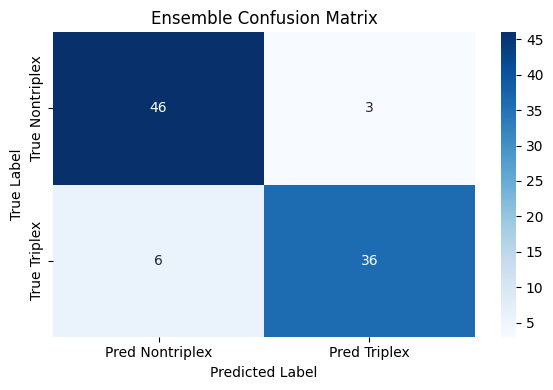

In [23]:
test_labels, probs_ensemble, pred_classes = evaluate_crossval_folds(datapath)
evaluate_ensemble_performance(test_labels, probs_ensemble, pred_classes)
